# Predicting Diamond Prices
## Phase 2: Statistical Modelling

## Group Name:

Group 14

#### Name(s) & ID(s) of Group Members:

 Ahamd Akkad s3920007 
 
 Faysal Abdiwahab s3783895

#### 

## Table of Contents
- [Introduction](#intro)
    + [Phase 1 Summary](#Phase-1-Summary)
    + [Report Overview](#Report-Overview)
    + [Overview of Methodology](#Overview-of-Methodology)
- [Statistical Modelling](#sm)
    + [Model Fitting](#Model-Fitting)
    + [Full Model Diagnostic Checks](#Full-Model-Diagnostic-Checks)
    + [Backwards Feature Selection](#Backwards-Feature-Selection)
- [Critique & Limitations](#cl)
- [Summary & Conclusions](#sc)

## Introduction <a id='intro'></a>


------

#### Phase 1 Summary

In phase 1, we conducted data cleaning in order to come up with a predictive model and understand the influence certain diamond features have on the price of a diamond. During our preprocessing, one of the changes we decided to make on our dataset was to use integer encoding on our ordinal descriptive features such as 'colour' and 'cut'. So, for this part of the project, we will not be performing any encoding, and will be using our cleaned dataset with the integer encoded columns. While visualising our dataset, we noticed that there is a strong correlation between x,y and z (dimensions of diamond), which implies some collinearity between the variables.  This collinearity complicates model estimation, and therefore we will be dropping these features later on in this phase.      

#### Report Overview

In this phase, using multiple linear regression, we will be performing several different analyses such as backwards feature selection, to try and find the model that can best predict diamond prices within an acceptable margin of error.

#### Overview of Methodology

The first step in our task is to create a regression model to examine the relationships between the independent variables and the response variable. 

This model is dependent on various conditions, so we will be using diagnostic checks to verify our assumptions on the data such as using graphical methods to check the validity of these conditions, this includes checking the constant variance condition using a plot of residuals vs. fitted, as well as checking if residuals follow a nearly normal distribution

## Statistical Modelling <a id='sm'></a>

--------

### Model Overview

We begin by fitting a multiple linear regression that predicts `price` using all of the avaliable features. We call this the full model. First let's take a quick peak at the clean data.

#### Module Imports

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

df = pd.read_csv('diamonds-cleaned.csv')
del df['Unnamed: 0']
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.00,1,6,3,62.8,61.0,6.31,6.34,3.97,6189
1,0.41,4,4,4,61.3,57.0,4.79,4.77,2.93,1076
2,1.74,4,1,1,61.6,57.0,7.67,7.74,4.75,8896
3,0.54,4,5,4,62.6,55.0,5.20,5.22,3.26,1732
4,1.00,4,2,2,61.9,57.0,6.43,6.39,3.97,4872


### Model Fitting

We will now construct a multiple regression model for `price` as the response variable and `carat`, `colour`, `clarity`, `depth` and `table` as the independent variables.

As mentioned in the phase 1 summary, since `x`, `y`, and `z` are almost exactly collinear to price, they will be dropped from the model here on.

In [83]:
formula_string_indep_vars = ' + '.join(df.drop(columns=['price','x', 'y', 'z']).columns)
formula_string = 'price ~ ' + formula_string_indep_vars
print('formula_string: ', formula_string)

formula_string:  price ~ carat + cut + color + clarity + depth + table


Now that we have defined our statistical model formula as a Python string, we fit an OLS (ordinary least squares) model to our dataset.

In [84]:
model_full = sm.formula.ols(formula=formula_string, data=df)
###
model_full_fitted = model_full.fit()
###
print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     933.3
Date:                Sun, 24 Oct 2021   Prob (F-statistic):          1.76e-265
Time:                        17:46:47   Log-Likelihood:                -4026.6
No. Observations:                 500   AIC:                             8067.
Df Residuals:                     493   BIC:                             8097.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -662.5071   3145.020     -0.211      0.8

In [85]:
print(f'''

The full model has an R-squared value of {model_full_fitted.rsquared:.3f}, and an adjusted
R-squared value of {model_full_fitted.rsquared_adj:.3f}. This means that 92% of the variance is explained by the model. 

By observing the p-values, we can see that most of them are relatively high, meaning at any level level of 
significance, we can conclude that there is no statistically significant relationship between those variables and the price of the diamonds. 
There are, however, a few variables with p-values that are in fact highly significant. 

''')



The full model has an R-squared value of 0.919, and an adjusted
R-squared value of 0.918. This means that 92% of the variance is explained by the model. 

By observing the p-values, we can see that most of them are relatively high, meaning at any level level of 
significance, we can conclude that there is no statistically significant relationship between those variables and the price of the diamonds. 
There are, however, a few variables with p-values that are in fact highly significant. 




We will now define a new data frame for actual age vs. predicted age and the residuals for the full model. We will use this data frame when plotting predicted values and the regression residuals.

In [86]:
residuals_full = pd.DataFrame({'actual': df['price'], 
                            'predicted': model_full_fitted.fittedvalues, 
                            'residual': model_full_fitted.resid})
residuals_full.head(10)

,actual,predicted,residual
0,6189,5840.244737,348.755263
1,1076,1235.159779,-159.159779
2,8896,9652.133075,-756.133075
3,1732,2486.428701,-754.428701
4,4872,4533.490316,338.509684
5,8184,8890.249858,-706.249858
6,4813,5425.298710,-612.298710
7,886,1219.194102,-333.194102
8,1990,2648.913889,-658.913889
9,2401,2750.068130,-349.068130


Plotting actual age values vs. predicted values.

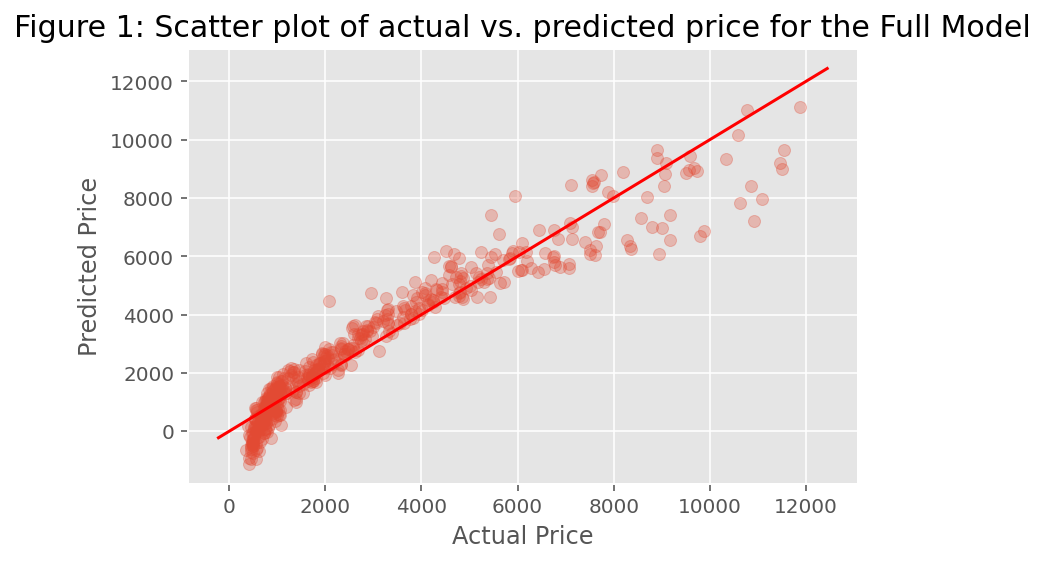

In [87]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_full['actual'], residuals_full['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Price');
plt.ylabel('Predicted Price');
plt.title('Figure 1: Scatter plot of actual vs. predicted price for the Full Model', fontsize=15);
plt.show();

From Figure 1, we observe that the model never produces a prediction above 12000  and  that there is s a nearly strong positive correlation between the model’s predictions and its actual results.

Notice that the model almost accurately predicts price until around 6000 USD, where it begins to underestimates the values. In particular, for diamonds between  8000 and 12000, the model predicts much lower prices. 


We will now check the diagnostics for the full model.

### Full Model Diagnostic Checks

In this part, we will be checking whether there are indications of violations of the regression assumptions for the full model.

These assumptions are:
1. Linearity of the relationship between price and the independent variables (done above)
2. Constant variance of the errors
3. Normality of the residual distribution
4. Statistical independence of the residuals (using fitted model)

First, we'll get a scatter plot of residuals (as a function of predicted `price`).

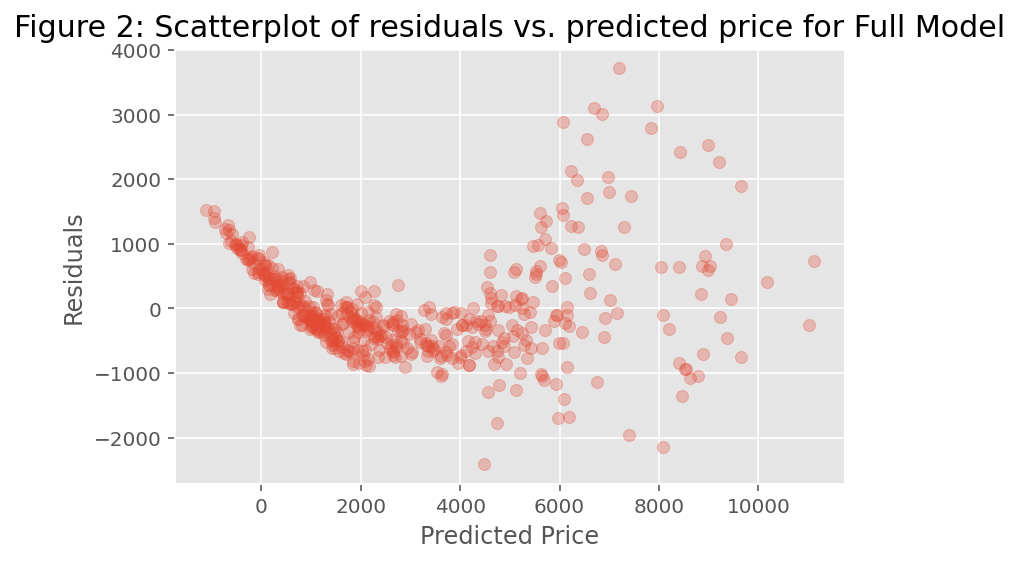

In [88]:
plt.scatter(residuals_full['predicted'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Predicted Price');
plt.ylabel('Residuals')
plt.title('Figure 2: Scatterplot of residuals vs. predicted price for Full Model', fontsize=15)
plt.show();

From Figure 2, we see that the residuals exhibit a banding pattern until about 4000 USD, and then the spread becomes more random. 
This pattern indicates that the constant variability assumption of linear regression is not quite satisfied in this case. 

Let's now plot actual price vs. residuals.

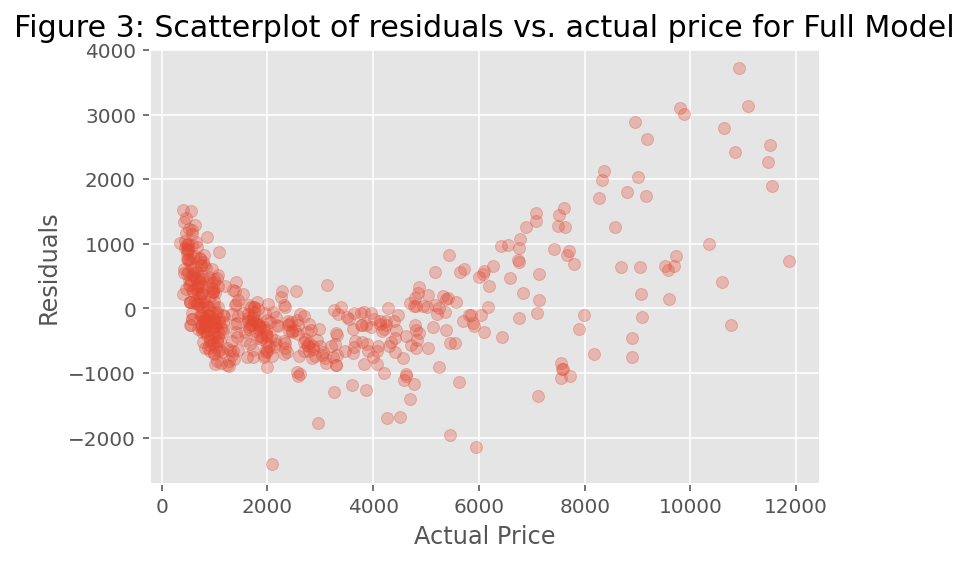

In [89]:
plt.scatter(residuals_full['actual'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Actual Price');
plt.ylabel('Residuals')
plt.title('Figure 3: Scatterplot of residuals vs. actual price for Full Model', fontsize=15)
plt.show();

Figure 3 looks very similar to Figure 1, suggesting that the residuals exhibit the same banding pattern.

Let's overlay the histograms of actual vs. predicted price on the same plot.

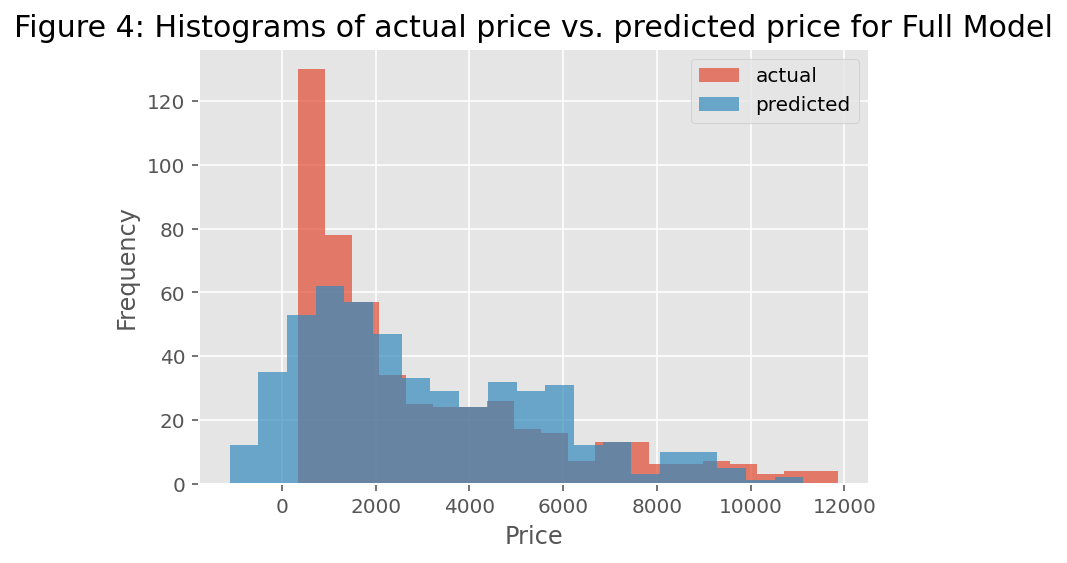

In [90]:
plt.hist(residuals_full['actual'], label='actual', bins=20, alpha=0.7);
plt.hist(residuals_full['predicted'], label='predicted', bins=20, alpha=0.7);
plt.xlabel('Price');
plt.ylabel('Frequency');
plt.title('Figure 4: Histograms of actual price vs. predicted price for Full Model', fontsize=15);
plt.legend()
plt.show();

We notice that their distributions are quite similar. with both the actual and predicted values being highly clustered around 1-2000 USD. 

Let's now have look at the histogram of the residuals.

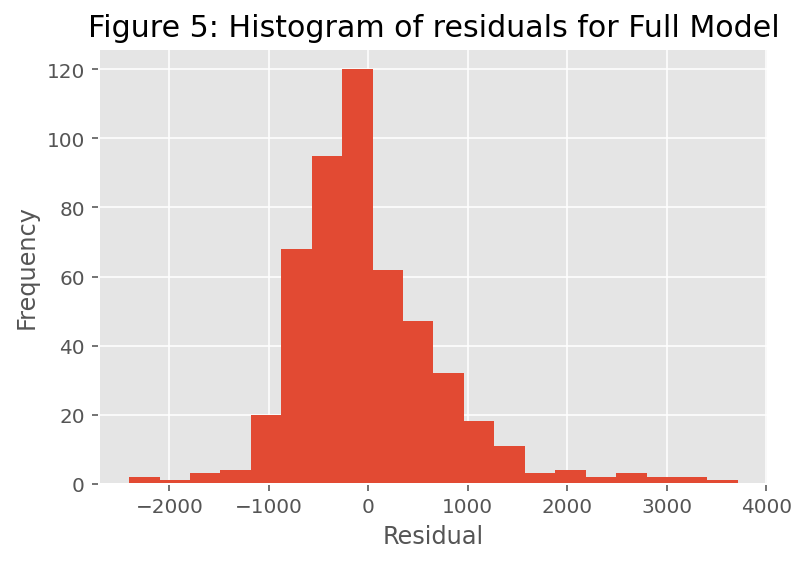

In [91]:
plt.hist(residuals_full['residual'], bins = 20);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Figure 5: Histogram of residuals for Full Model', fontsize=15);
plt.show();

From Figure 5, the histogram of residuals looks nearly symmetric, however slightly right-skewed, indicating that the normality assumption of linear regression is not significantly violated in this particular case.

### Backwards Feature Selection

We now perform backwards feature selection using p-values. 

In [92]:
## create the patsy model description from formula
patsy_description = patsy.ModelDesc.from_formula(formula_string)

# initialize feature-selected fit to full model
linreg_fit = model_full_fitted

# do backwards elimination using p-values
p_val_cutoff = 0.05

## WARNING 1: The code below assumes that the Intercept term is present in the model.
## WARNING 2: It will work only with main effects and two-way interactions, if any.

print('\nPerforming backwards feature selection using p-values:')

while True:

    # uncomment the line below if you would like to see the regression summary
    # in each step:
    ### print(linreg_fit.summary())

    pval_series = linreg_fit.pvalues.drop(labels='Intercept')
    pval_series = pval_series.sort_values(ascending=False)
    term = pval_series.index[0]
    pval = pval_series[0]
    if (pval < p_val_cutoff):
        break
    term_components = term.split(':')
    print(f'\nRemoving term "{term}" with p-value {pval:.4}')
    if (len(term_components) == 1): ## this is a main effect term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0])]))    
    else: ## this is an interaction term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0]), 
                                                        patsy.EvalFactor(term_components[1])]))    
        
    linreg_fit = smf.ols(formula=patsy_description, data=df).fit()
    
###
## this is the clean fit after backwards elimination
model_reduced_fitted = smf.ols(formula = patsy_description, data = df).fit()
###
    
#########
print("\n***")
print(model_reduced_fitted.summary())
print("***")
print(f"Regression number of terms: {len(model_reduced_fitted.model.exog_names)}")
print(f"Regression F-distribution p-value: {model_reduced_fitted.f_pvalue:.4f}")
print(f"Regression R-squared: {model_reduced_fitted.rsquared:.4f}")
print(f"Regression Adjusted R-squared: {model_reduced_fitted.rsquared_adj:.4f}")


Performing backwards feature selection using p-values:

Removing term "cut" with p-value 0.871

Removing term "table" with p-value 0.3159

Removing term "depth" with p-value 0.3708

***
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     1870.
Date:                Sun, 24 Oct 2021   Prob (F-statistic):          6.69e-270
Time:                        17:46:50   Log-Likelihood:                -4027.5
No. Observations:                 500   AIC:                             8063.
Df Residuals:                     496   BIC:                             8080.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef  

Similar to what we did for the full model, let's define a new data frame for actual priced vs. predicted price and the residuals for the reduced model.

In [93]:
residuals_reduced = pd.DataFrame({'actual': df['price'], 
                            'predicted': model_reduced_fitted.fittedvalues, 
                            'residual': model_reduced_fitted.resid})
residuals_reduced.head(10)

,actual,predicted,residual
0,6189,5943.435863,245.564137
1,1076,1225.398861,-149.398861
2,8896,9623.291116,-727.291116
3,1732,2491.576579,-759.576579
4,4872,4532.190580,339.809420
5,8184,8803.670490,-619.670490
6,4813,5472.407484,-659.407484
7,886,1178.296141,-292.296141
8,1990,2617.770944,-627.770944
9,2401,2791.226251,-390.226251


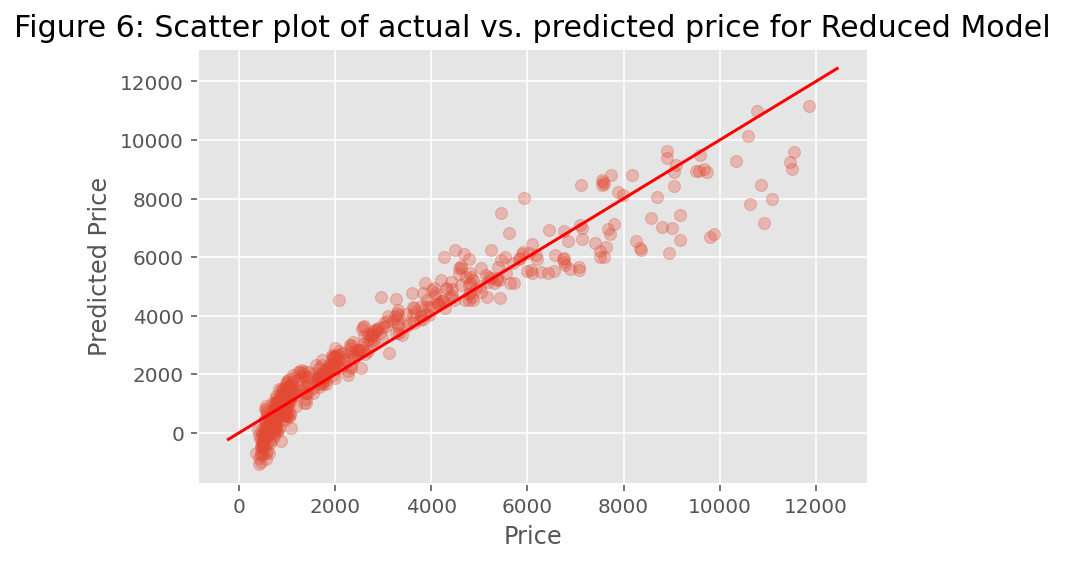

In [94]:
plt.scatter(residuals_reduced['actual'], residuals_reduced['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Price');
plt.ylabel('Predicted Price');
plt.title('Figure 6: Scatter plot of actual vs. predicted price for Reduced Model', fontsize=15);
plt.show(); 

This model returns an Adjusted R-squared of 0.92, meaning the reduced model explains about 92% of the variance. 
Figure 6, which depicts predicted vs actual price for the reduced model, follows a somewhat strong positive linear relationship, and is almost identical to the plot for the full model.  



Let's move on and perform the diagnostic checks on this reduced model. 

### Reduced Model Diagnostic Checks

First step is to get a scatter plot of residuals (as a function of predicted age).

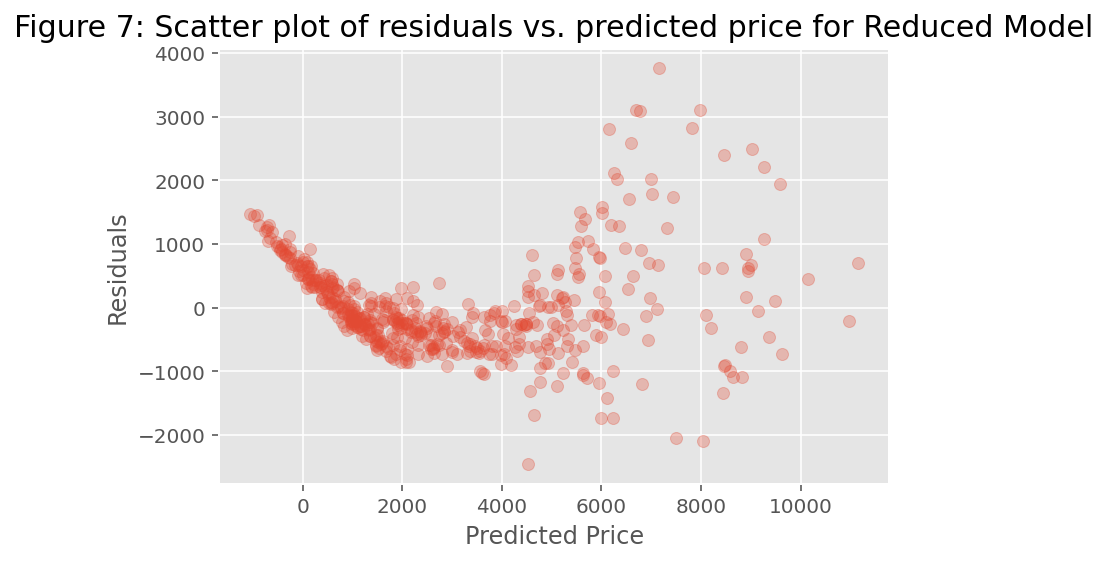

In [95]:
plt.scatter(residuals_reduced['predicted'], residuals_reduced['residual'], alpha=0.3);
plt.xlabel('Predicted Price');
plt.ylabel('Residuals')
plt.title('Figure 7: Scatter plot of residuals vs. predicted price for Reduced Model', fontsize=15)
plt.show();

Similar to Figure 1 and 3, this plot suggests that the residuals exhibit the same banding pattern. Again, the presence of a pattern in the residual plot implies non-linearity in our data.  That is, since observations and residuals are independent, we would not expect to see an increasing or decreasing trend in the scatterplot of residuals vs. fitted data.


Let's now have look at the histogram of the residuals for the reduced model.

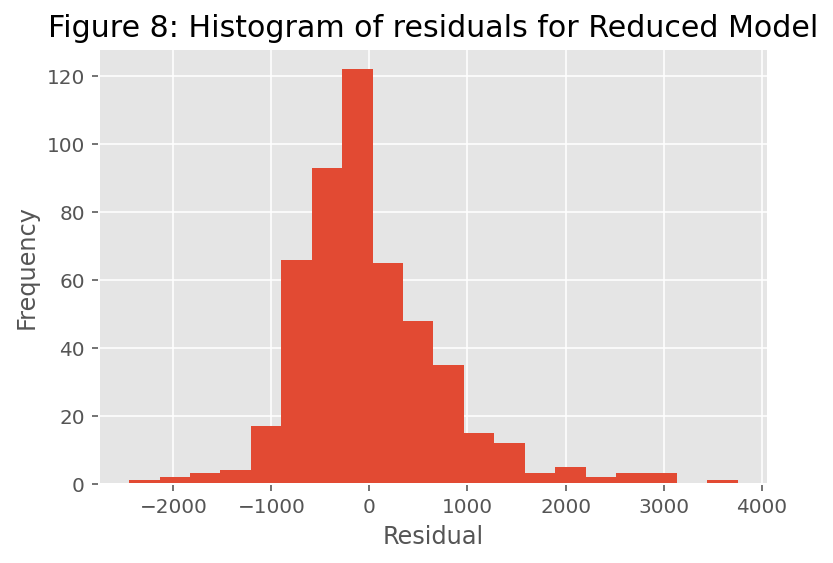

In [96]:
plt.hist(residuals_reduced['residual'], bins = 20);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Figure 8: Histogram of residuals for Reduced Model', fontsize = 15)
plt.show();

From Figure 8, there is again a almost symmetric distribution of the histogram around zero, which suggests that the residuals for the reduced model are somewhat normally distributed

## Critique & Limitations <a id='cl'></a>

This model only includes information about the prices for diamonds at a specific point in time. Therefore, the diamond market is probably quite different than it is now. 

From our diagnostic checks, we see that there were violations in the constant variablity seen by the residual plot in figure 2, this presence of a pattern in the residual plot implies non-linearity in our data and this could have been avoided by introducing an interaction between some predictors. 

Another problem with our dataset was that, from phase one, most independent variables as well as the dependent variable did not have a normal distribution. 
Thus could have been fixed by using perhaps a log scale to transform the variables. 
In turn this would have helped with accounting for inconsistent variability or nonlinear relationships between predictors and the outcome. 

Additionally we could have introduced out additional variables to fill some of the gaps in the model. 


We did find, however, that feature selection combined with multiple linear regression is 
accurate in predicting the price of a diamond using its intrinsic
characteristics. 



## Summary & Conclusions <a id='sc'></a>

### Project Summary

In the first phase of the project, we had the tasks of data cleaning, preprocessing and visualisation. This consisted of removing  null values, removing outliers, integer encoding, and sampling the dataset in order to begin our regression analysis. 

In phase 2, we try to take a deep dive into understanding the correlation between the features and the diamond price. Through multiple regression analysis, we can depict, to any conventional degree of significance, which factors are most influential in predicting the price of a diamond. 

The point of our study is to help buyers understand whether or not they are overpaying for the diamond they buy. 

### Summary of Findings

Using our independent variables, we were able to create a full model with an Adjusted R-squared value of about 92%. After backwards variable selection with a p-value significance value of 0.05, we were able to maintain the same performance after dropping our `cut` `table` and `depth` variables. Before backwards selection, however, we also decided to drop `x`, `y`, `z` variables. This was because during our investigation, we noticed that there was some collinearity between those variables. 

Our final model has 3 variables all together, (`carat`, `colour`, `clarity`) with a full model p-value of 0.

Diagnostic checks with residual scatter plots indicate that, rather than being random and centered around 0, the residuals exhibit somewhat of a banding pattern. This indicates that the constant variability assumption of linear regression is not satisfied for this dataset. On the other hand, however, the residual histograms imply that there are no significant violations of the normality assumption on the residuals.

The final model has an Adjusted R-squared value of about 92%. Which means the features we used were sufficient for accurately predicting the price of diamond within a multiple linear regression framework. 

A way to improve our model in the future could involve adding some more interaction terms which could would result in some improvement for the Adjusted R-squared value. 


### Conclusions

Our regression model appears to predict price correctly within  ±900 USD in general, though this is too big of a margin of error for the model to be useful for any practical purposes. 

The model we have built can be used for inference of how the different predictors influence the price, however it is not perfect. This is due to the presence of non-linearity and non-constant variance of errors. Moreover, the data could be scaled in order to find a better model. That said, it still helps by providing good estimations of the significant relations between the predictors and the response variable. 


Although we can predict the price of a diamond based on the features that make up diamonds, we cannot conclude with this project that where you buy your diamond from is irrelevant. However, you can use a model like this to get a sense of whether or not you are getting your money's worth. 

References:
    
stats_tutorials/Regression_Case_Study1_web.ipynb at master · vaksakalli/stats_tutorials. (2021). Retrieved 23 October 2021, from https://github.com/vaksakalli/stats_tutorials/blob/master/Regression_Case_Study1_web.ipynb